In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from matplotlib.colors import LogNorm
import astropy.units as u
import astropy.constants as c
import glob
import matplotlib as mpl

In [39]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick.major', size=6)    # size of the tick markers
plt.rc('ytick.major', size=6)    # size of the tick markers
plt.rc('xtick.minor', size=4)    # size of the tick markers
plt.rc('ytick.minor', size=4)    # size of the tick markers
# BP Plot stylization parameters.

colors = mpl.colormaps['Dark2'].colors

In [40]:
dir = r'/home/baparker/GitHub/Research/CCDs/Sophia/Data/20241102/PTC'
save_dir = r'/home/baparker/GitHub/Research/CCDs/Sophia/Photos'

science_in_list = glob.glob(dir + r'/science_*_bd.fits')
dark_in_list = glob.glob(dir + r'/dark_*_b.fits')

science_in_list.sort()
dark_in_list.sort()

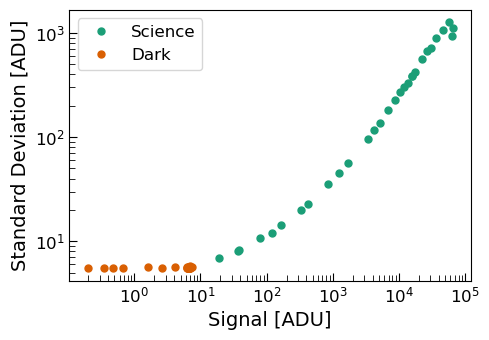

In [42]:
locs = [950] #0, 256, 512, 768, 1024]#, 1280, 1536]
step = 50
# Exclude very edges

fig, ax = plt.subplots(layout='tight', figsize=(5,3.5))
# BP Create plotting figure.

for file in science_in_list:
    hdul = fits.open(file)
    data = hdul[0].data
    hdul.close()

    for i in locs:
        for j in locs:
            #print(i,j)
            region = data[i:i+step, j:j+step]

            #plt.imshow(region)
            #plt.show()

            signal = np.mean(region)
            error = np.std(region)

            ax.plot(signal, error, ls='', marker='.', color=colors[0], markersize=10)
ax.plot(signal, error, ls='', marker='.', color=colors[0], label='Science', markersize=10)

for file in dark_in_list:
    hdul = fits.open(file)
    data = hdul[0].data
    hdul.close()

    for i in locs:
        for j in locs:
            #print(i,j)
            region = data[i:i+step, j:j+step]

            #plt.imshow(region)
            #plt.show()

            signal = np.mean(region)
            error = np.std(region)

            ax.plot(signal, error, ls='', marker='.', color=colors[1], markersize=10)
ax.plot(signal, error, ls='', marker='.', color=colors[1], label='Dark', markersize=10)

ax.set_xlabel(r'Signal [ADU]')
ax.set_ylabel(r'Standard Deviation [ADU]')
ax.tick_params(axis='both', direction='in', which='both')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')
fig.tight_layout()
plt.savefig(save_dir + r'/Sophia_PTC_Bias_20241102.png'.format(step),dpi = 500)
plt.show()